# LSTM Practice
* 2019/08/17 kwanki.ahn@samsung.com
* reference : https://3months.tistory.com/168

데이터를 임포트합니다. 데이터는 날짜별로 특정한 값이 있는 데이터입니다. Unadjusted이 Raw 값이고, Seaonally adjusted는 Season의 효과를 보정한 값입니다. 보통 주식과 같은 시계열 데이터는 Season에 의한 효과가 있는데, Seasonally adjusted는 이 Season에 의한 효과를 보정하여 전체적인 추세만 보고자할 때 사용하는 변수입니다. 우리가 학습할 변수는 Season에 의한 효과를 보정하지 않은 Unadjusted입니다

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('./cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


## 전처리

https://datascienceschool.net/view-notebook/a49bde24674a46699639c1fa9bb7e213/

때로는 데이터프레임에 인덱스로 들어가 있어야 할 데이터가 일반 데이터 열에 들어가 있거나 반대로 일반 데이터 열이어야 할 것이 인덱스로 되어 있을 수 있다. 이 때는 set_index 명령이나 reset_index 명령으로 인덱스와 일반 데이터 열을 교환할 수 있다.

    set_index : 기존의 행 인덱스를 제거하고 데이터 열 중 하나를 인덱스로 설정
    reset_index : 기존의 행 인덱스를 제거하고 인덱스를 데이터 열로 추가

In [8]:
from pandas.tseries.offsets import MonthEnd

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


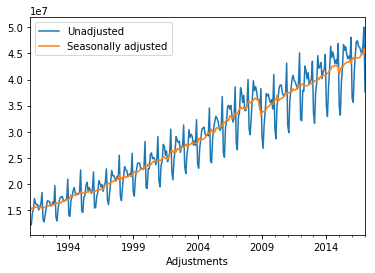

In [9]:
df.plot()

## 트레이닝셋 테스트셋 SPLIT

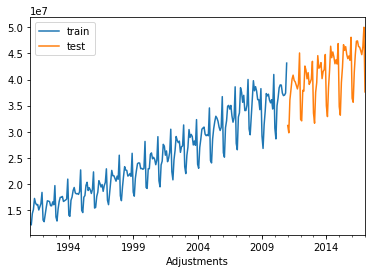

In [11]:
split_date = pd.Timestamp('01-01-2011')
# 2011/1/1 까지의 데이터를 트레이닝셋.
# 그 이후 데이터를 테스트셋으로 한다.

train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]
# Feature는 Unadjusted 한 개

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [19]:
print(type(train))
train[:5]

<class 'pandas.core.frame.DataFrame'>


,Unadjusted
Adjustments,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072
1991-04-30,15108570
1991-05-31,17225734


## 변수 Scaling

MinMax Scaling을 통해 변수를 Scaling합니다. MinMax Scaling : http://3months.tistory.com/167
그러면 아래와 같이 Scaling 된 것을 볼 수 있고, scaling의 결과는 2차원의 numpy ndarray 타입으로 변환이 되게 됩니다.

In [18]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

print(type(train_sc))
train_sc[:5]

<type 'numpy.ndarray'>


array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761]])

In [45]:
test_sc[:5]

array([[0.61423187],
       [0.56926634],
       [0.77259579],
       [0.83505683],
       [0.89993326]])

## Pandas Dataframe으로 변환

In [21]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


## pandas shift를 통해 Window 만들기
shift는 이전 정보 다음 row에서 다시 쓰기 위한 pandas의 함수입니다. 이를 통해 아래와 같이 과거의 값들을 shift_s 와 같은 형태로 저장할 수 있습니다. 과거값은 총 12개를 저장하며, timestep은 12개가 됩니다. 우리의 목적은 과거값 shift1~12를 통해 현재값 Scaled를 예측하는 것입니다.

In [22]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


## 트레이닝셋과 테스트셋 만들기
dropna를 통해 NaN이 있는 데이터를 제거하고, shift_1 ~ shift_12는 X로 Scaled는 Y로 지정을 합니다.

In [29]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [30]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [31]:
y_train.head()

,Scaled
Adjustments,
1992-01-31,0.030027
1992-02-29,0.019993
1992-03-31,0.065964
1992-04-30,0.109831
1992-05-31,0.149130


## 다시 ndarray로 변환하기
실제 deep learning 모델의 트레이닝과 테스트로 사용되는 데이터는 일반적으로 numpy의 ndarray입니다

In [34]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [33]:
print(X_train.shape)
print(X_train[:10])
print(y_train.shape)
print(y_train[:10])

(228, 12)
[[0.20091289 0.13173822 0.11139526 0.09230917 0.12617398 0.12395846
  0.13514108 0.16362761 0.09531795 0.0704258  0.         0.01402033]
 [0.03002688 0.20091289 0.13173822 0.11139526 0.09230917 0.12617398
  0.12395846 0.13514108 0.16362761 0.09531795 0.0704258  0.        ]
 [0.01999285 0.03002688 0.20091289 0.13173822 0.11139526 0.09230917
  0.12617398 0.12395846 0.13514108 0.16362761 0.09531795 0.0704258 ]
 [0.06596369 0.01999285 0.03002688 0.20091289 0.13173822 0.11139526
  0.09230917 0.12617398 0.12395846 0.13514108 0.16362761 0.09531795]
 [0.10983126 0.06596369 0.01999285 0.03002688 0.20091289 0.13173822
  0.11139526 0.09230917 0.12617398 0.12395846 0.13514108 0.16362761]
 [0.14912986 0.10983126 0.06596369 0.01999285 0.03002688 0.20091289
  0.13173822 0.11139526 0.09230917 0.12617398 0.12395846 0.13514108]
 [0.14718865 0.14912986 0.10983126 0.06596369 0.01999285 0.03002688
  0.20091289 0.13173822 0.11139526 0.09230917 0.12617398 0.12395846]
 [0.14464787 0.14718865 0.14912

## 최종 트레이닝셋과 테스트셋의 X 만들기
<p style='color:red'>이부분이 중요한데, keras에서는 RNN 계열의 모델을 트레이닝할 대 요구되는 데이터의 형식이 있습니다. 바로 3차원 데이터여야하며 각각의 차원은 <b>(size, timestep, feature) 을 순서</b>대로 나타내주어야하는 것입니다. 따라서 이 형태로 데이터를 reshape 해주어야합니다. 일반적인 MLP 모델에서는 size와 feature만 있기 때문에 2차원이지만, RNN에서는 "시간" 이라는 개념이 있기 때문에 차원이 한 차원 늘어나게 된 것입니다. 합리적인 데이터 구조라고 볼 수 있습니다</p>

In [36]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [51]:
print("최종 DATA")
print(X_train_t.shape)
print(X_train_t[:2])
print(y_train[:2])
print(X_test_t.shape)
print(X_test_t[:2])
print(y_test[:2])

최종 DATA
(228, 12, 1)
[[[0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]
  [0.0704258 ]
  [0.        ]
  [0.01402033]]

 [[0.03002688]
  [0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]
  [0.0704258 ]
  [0.        ]]]
[[0.03002688]
 [0.01999285]]
(61, 12, 1)
[[[1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]
  [0.77259579]
  [0.56926634]
  [0.61423187]]

 [[0.65198848]
  [1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]
  [0.77259579]
  [0.56926634]]]
[[0.65198848]
 [0.6431242 ]]


## LSTM 모델 만들기

아래와 같이 keras를 통해 LSTM 모델을 만들 수 있습니다. <b>input_shape=(timestep, feature)으로</b> 만들어줍니다. size는 모델 설계시에는 중요하지 않으므로, feature, timestep만 모델에 알려주면 됩니다. 또 예측하고자하는 target의 갯수가 1이므로 마지막에 Dense(1)을 하나 추가해줍니다. 또한 실제 연속적인 값을 예측하는 것이기 때문에 loss function은 mean squared error가 됩니다. 또한 일반적으로 optimizer는 adam을 자주 사용합니다

In [66]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [67]:
# early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
# model.fit(X_train_t, y_train, epochs=100,
#           batch_size=30, verbose=1, callbacks=[early_stop])

hist = model.fit(X_train_t, y_train, epochs=50, batch_size=30, verbose=1, validation_data=(X_test_t, y_test))

Train on 228 samples, validate on 61 samples
Epoch 1/50
228/228 [==============================] - 0s - loss: 0.2278 - acc: 0.0000e+00 - val_loss: 0.7026 - val_acc: 0.0000e+00
Epoch 2/50
228/228 [==============================] - 0s - loss: 0.1459 - acc: 0.0000e+00 - val_loss: 0.4568 - val_acc: 0.0000e+00
Epoch 3/50
228/228 [==============================] - 0s - loss: 0.0801 - acc: 0.0000e+00 - val_loss: 0.2589 - val_acc: 0.0000e+00
Epoch 4/50
228/228 [==============================] - 0s - loss: 0.0360 - acc: 0.0000e+00 - val_loss: 0.1068 - val_acc: 0.0000e+00
Epoch 5/50
228/228 [==============================] - 0s - loss: 0.0154 - acc: 0.0044 - val_loss: 0.0347 - val_acc: 0.0000e+00
Epoch 6/50
228/228 [==============================] - 0s - loss: 0.0174 - acc: 0.0044 - val_loss: 0.0247 - val_acc: 0.0000e+00
Epoch 7/50
228/228 [==============================] - 0s - loss: 0.0154 - acc: 0.0044 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 8/50
228/228 [==============================

In [85]:
def show_train_progress(hist):
    # https://tykimos.github.io/2017/07/09/Training_Monitoring/
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()  

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

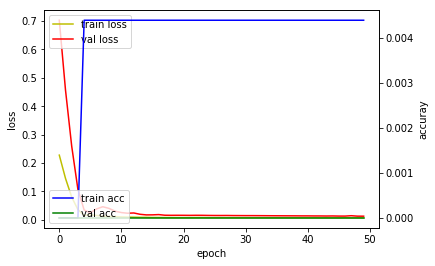

In [86]:
show_train_progress(hist)

# 후기
예제가, 문제 정의를 잘 못 한 거같다.
인풋 데이터까지는 괜찮은데, 예측하는 라벨이 의미가 없다.
예를들어 오랜 시간동안 특정한 패턴을 가지는 데이터는 category 1로
다른 패턴을 가지는 데이터는 category 2로, classification 하는 문제였다면 어떨까?

df
- train (~2011.01.01)<br>
  |- train_sc (MinMaxScaler)<br>
     |- X_train, y_train<br>
     |- X_train_t (228, 12, 1)<br>
- test (2011.01.01~)<br>
  |- test_sc (MinMaxScaler)<br>
     |- X_test, y_test <br>
     |- X_test_t (61, 12, 1)<br>